<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


### Note to the Peer Reviewer

Due to problems creating a Watson Studio Account, I have decided to upload my code in GitHub and share my output through it. The Watson Studio Account could not be created even when setting my country as USA or Canada as instructed by the Coursera instructions. 

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
# !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

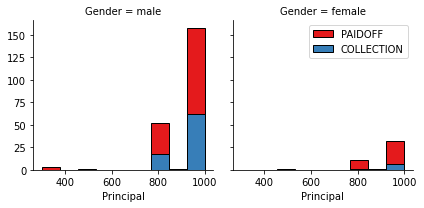

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

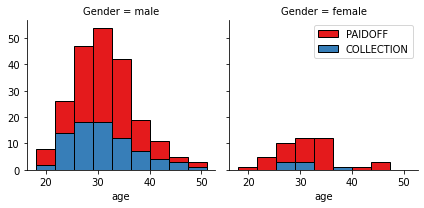

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


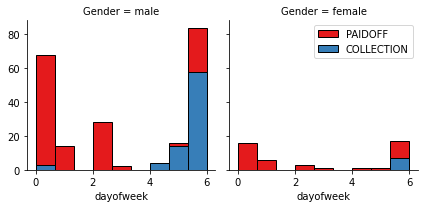

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
# Import the needed packages and modules 
from sklearn.model_selection import train_test_split 

# Create a split between test and train data (within the loan_train.csv) 
# Use 20 percent of the data as the test size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2021)

print('Train set:', X_train.shape,  y_train.shape)
print('Test set:', X_test.shape,  y_test.shape)
print(np.ceil(0.20 * X.shape[0]))

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
70.0


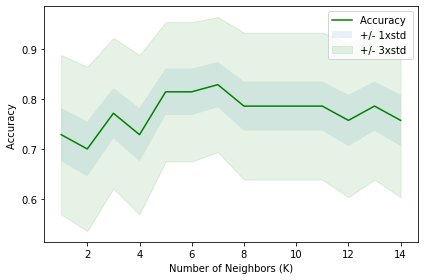

Max Accuracry:  0.8285714285714286
K =  7  neighbors


In [21]:
# Import the packages 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 

# Determine the most appropriate K value by using the k-value with the most accurate answer
ks = 15

mean_acc = np.zeros((ks - 1)) # placeholder for mean_accuracy 
std_acc = np.zeros((ks - 1))

for k_val in range(1, ks): 
    
    # Train the model 
    KNN_model = KNeighborsClassifier(n_neighbors=k_val).fit(X_train, y_train)
    y_pred = KNN_model.predict(X_test)
    
    mean_acc[k_val-1] = metrics.accuracy_score(y_test, y_pred)
    std_acc[k_val-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])
    
# plotting the accuracy of the model under different k 
plt.plot(range(1,ks),mean_acc,'g')
plt.fill_between(range(1,ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print('Max Accuracry: ', np.max(mean_acc))
print('K = ', np.where(mean_acc == np.max(mean_acc))[0][0] + 1, ' neighbors')

In [22]:
# Setting up the model for the loan_test.csv = using the entire loan_train this time
KNN_7 = KNeighborsClassifier(n_neighbors=7).fit(X, y)

# Decision Tree


In [23]:
# Importing the decision tree classifier 
from sklearn.tree import DecisionTreeClassifier


#Training the Tree on the TRAIN Set split of Loan_Train
LoanTree = DecisionTreeClassifier(criterion = "entropy", max_depth = 3)
LoanTree.fit(X_train, y_train)

#Making a prediction 
y_pred_LoanTree = LoanTree.predict(X_test)

# Comparing the outcome 
print(y_test[-5:])
print(y_pred_LoanTree[-5:])

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred_LoanTree))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
DecisionTrees's Accuracy:  0.8


# Support Vector Machine


In [24]:
from sklearn import svm

#Deciding the best possible kernel 
kernel_list =['linear', 'poly', 'sigmoid', 'rbf']

for kernel_i in kernel_list: 
    svm_Loan = svm.SVC(kernel = kernel_i)
    svm_Loan.fit(X_train, y_train)
    
    y_pred_svm = svm_Loan.predict(X_test)
    
    accuracy = metrics.jaccard_score(y_test, y_pred_svm, pos_label='PAIDOFF')
    print(f'Kernel: {kernel_i} with {accuracy} accuracy')

Kernel: linear with 0.8 accuracy
Kernel: poly with 0.7681159420289855 accuracy
Kernel: sigmoid with 0.782608695652174 accuracy
Kernel: rbf with 0.7971014492753623 accuracy


In [25]:
# Training the model on the entire loan Train set and using LINEAR kernel
svm_Loan_Linear = svm.SVC(kernel='linear')
svm_Loan.fit(X,y)



SVC()

# Logistic Regression


In [26]:
# Import the logistic regression model 
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(C = 5.00, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)

In [27]:
y_pred_LR_prob = LR_model.predict_proba(X_test)
y_pred_LR_prob

array([[0.01114698, 0.98885302],
       [0.04097233, 0.95902767],
       [0.25730313, 0.74269687],
       [0.00990781, 0.99009219],
       [0.02246379, 0.97753621],
       [0.32823369, 0.67176631],
       [0.39806271, 0.60193729],
       [0.01353931, 0.98646069],
       [0.33266675, 0.66733325],
       [0.37569231, 0.62430769],
       [0.32634564, 0.67365436],
       [0.04131062, 0.95868938],
       [0.0377671 , 0.9622329 ],
       [0.39714202, 0.60285798],
       [0.50188077, 0.49811923],
       [0.49044131, 0.50955869],
       [0.01794254, 0.98205746],
       [0.0212282 , 0.9787718 ],
       [0.03561223, 0.96438777],
       [0.02817484, 0.97182516],
       [0.32586436, 0.67413564],
       [0.3301273 , 0.6698727 ],
       [0.49472803, 0.50527197],
       [0.49258454, 0.50741546],
       [0.03807997, 0.96192003],
       [0.47403419, 0.52596581],
       [0.51688127, 0.48311873],
       [0.01933092, 0.98066908],
       [0.33775656, 0.66224344],
       [0.04411472, 0.95588528],
       [0.

# Model Evaluation using Test set


In [28]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [29]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [30]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [31]:
### Cleaning the Data

# Converting to proper date times 
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Checking the dates 
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Replacing the categorical values into numerical values 
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# one hot encoding
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)



In [32]:
#Standardizing the test features
X_loan_test = Test_Feature.copy()
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)

y_loan_test = test_df['loan_status'].values

# Apply the different models to the test set 
y_pred_KNN = KNN_7.predict(X_loan_test)
y_pred_Tree = LoanTree.predict(X_loan_test)
y_pred_SVM = svm_Loan.predict(X_loan_test)
y_pred_LR = LR_model.predict(X_loan_test)

y_pred_proba_LR = LR_model.predict_proba(X_loan_test)

In [33]:
###Applying the Jaccard, F1-Score, and LogLoss for different models
results = [y_pred_KNN, y_pred_Tree, y_pred_SVM, y_pred_LR]
model_type = ['KNN', 'Tree', 'SVM', 'LogRes']
# Jaccard Score:

print('Jaccard Score')
for i in range(4): 
    print(f'Model: {model_type[i]}, Score: ',jaccard_score(y_loan_test, results[i], pos_label='PAIDOFF'))
    
print('F1 Score')
for i in range(4): 
    print(f'Model: {model_type[i]}, Score: ',f1_score(y_loan_test, results[i], pos_label='PAIDOFF'))
    
print('LogLoss:', log_loss(y_loan_test, y_pred_proba_LR))

Jaccard Score
Model: KNN, Score:  0.7
Model: Tree, Score:  0.7547169811320755
Model: SVM, Score:  0.7222222222222222
Model: LogRes, Score:  0.7222222222222222
F1 Score
Model: KNN, Score:  0.823529411764706
Model: Tree, Score:  0.8602150537634409
Model: SVM, Score:  0.8387096774193549
Model: LogRes, Score:  0.8387096774193549
LogLoss: 0.49156795320074737


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.7       | 0.824        | NA      |
| Decision Tree      | 0.755      | 0.860       | NA      |
| SVM                | 0.722       | 0.839        | NA      |
| LogisticRegression | 0.722       | 0.839     | 0.491       |


The Best Classifier according to the scoring method is the Decision Tree



<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
